In [38]:
# basic dataframe and operations
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# manipulation and preprocessing
from sklearn.preprocessing import Normalizer, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

# models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier

# measuring results
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, mean_absolute_error, roc_auc_score, precision_score, recall_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

# warning suppression
import warnings
from sklearn.exceptions import ConvergenceWarning

In [39]:
    # Import the csv training dataset to a pandas dataframe
# The dataset is expected in the same directory as this notebook
#   under a subfolder path datasets/
data_raw_input = pd.read_csv('datasets/train.csv')
# Show the shape of the dataset
data_raw_input.shape


(5634, 21)

In [40]:
# Display a few rows from the training data
data_raw_input.head(20)

,id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,...,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,label
0,1815,Male,0,Yes,Yes,12,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.70,258.35,0
1,5947,Female,0,No,No,42,Yes,No,DSL,Yes,...,Yes,Yes,No,Yes,One year,No,Credit card (automatic),73.90,3160.55,1
2,3882,Male,0,Yes,No,71,Yes,Yes,DSL,Yes,...,No,Yes,No,No,Two year,No,Bank transfer (automatic),65.15,4681.75,0
3,2390,Male,0,Yes,Yes,71,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,No,Electronic check,85.45,6300.85,0
4,3677,Male,0,No,No,30,Yes,No,DSL,Yes,...,No,Yes,Yes,No,One year,No,Electronic check,70.40,2044.75,0
5,612,Female,0,Yes,Yes,9,Yes,No,DSL,Yes,...,Yes,Yes,No,No,Month-to-month,No,Mailed check,65.00,663.05,1
6,589,Male,0,Yes,No,72,Yes,Yes,Fiber optic,Yes,...,Yes,No,No,Yes,Two year,Yes,Electronic check,99.15,7422.1,0
7,2688,Male,0,No,No,28,Yes,No,Fiber optic,No,...,Yes,Yes,No,Yes,Month-to-month,No,Electronic check,91.00,2626.15,0
8,1551,Male,1,Yes,No,6,Yes,Yes,Fiber optic,No,...,Yes,No,No,No,Month-to-month,Yes,Electronic check,80.80,457.1,0
9,2891,Female,1,Yes,Yes,47,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,No,Bank transfer (automatic),70.55,3309.25,1


In [41]:
# Get the count of nulls per column
# Turns out we don't have any
print("Nulls:")
print(data_raw_input.isnull().sum().sum())
print("Na count:")
print(data_raw_input.isna().sum().sum())
print("Duplicate rows:")
print(data_raw_input.duplicated(keep='first').sum())

# In attempting to change total_charges from string to numeric I received an error that there were some
#   values in there that were just ' ' -- a non-empty string that contains just a space. Now I'll formally detect it.
print(data_raw_input.columns[data_raw_input.isin([' ']).any()])

Nulls:
0
Na count:
0
Duplicate rows:
0
Index(['total_charges'], dtype='object')


### Dealing with total_charges

The values are empty strings with a space in them, ' ', but the column needs to be changed to float. So I'll first run an imputer over them to replace that, then we'll change to numeric data type.

Since we'll need to do this on the prediction to submit I've made a function to do this so we can reuse it at predict time.

In [ ]:
# Class: Multiprep
# Purpose: To preprocess all features. 
class MultiPrep:
    feature_encoders={}
    def destroy_encoders(self):
        self.feature_encoders = {}                   # overwrite the old encoders with an empty collection
        
    def fit_text_encoders(self, df_features):
        non_numeric_columns = df_features.select_dtypes(exclude='number').columns   # get a list of non-numeric cols
        for col in non_numeric_columns:         # loop through those columns to fit an encoder
            encoder = LabelEncoder()            # make a new label encoder for this column
            encoder.fit(df_features[col])       # fit this encoder
            self.feature_encoders[col] = encoder     # add it to the encoders collection for later use

    # fit a normalizer for all numerics
    def fit_scaler(self, df_features):
        # note I'm not caching the "this model has not been fit" error, like I would for a real app
        numeric_columns = df_features.select_dtypes(include='number').columns   # get a list of numeric cols
        scaler = StandardScaler()
        scaler.fit(df_features[numeric_columns])    # apply the transform
        self.feature_encoders['numerics'] = scaler  # preserve the numeric scaler 
     
    # encode all labels
    def transform_encode_all(self, df_features):
        # make a copy to work on so we can call this repeatedly
        df_local = df_features
        
        # note I'm not caching the "this model has not been fit" error, like I would for a real app
        non_numeric_columns = df_local.select_dtypes(exclude='number')   # get a list of non-numeric cols
        for col in non_numeric_columns:         # loop through them
            df_local[col] = self.feature_encoders[col].transform(df_local[col])    # apply the transform
        return df_local     
    
    # normalize all numerics
    def transform_scale_all(self, df_features):
        # make a copy to work on so we can call this repeatedly
        df_local = df_features        
        # note I'm not caching the "this model has not been fit" error, like I would for a real app
        numeric_columns = df_local.select_dtypes(include='number').columns   # get a list of numeric cols
        df_local[numeric_columns] = self.feature_encoders['numerics'].transform(df_local[numeric_columns])    # apply the transform
        return df_local
            
    def decode_all(self, df_features):
        # make a copy to work on so we can call this repeatedly
        df_local = df_features        
        non_numeric_columns = df_local.select_dtypes(exclude='number')   # get the non-numeric cols
        for col in non_numeric_columns:         # loop through them
            df_local[col] = self.feature_encoders[col].inverse_transform(df_local[col])    # decode the data
        return df_local
    
    
# split the x and y data. Doing it outside the transformation as we don't want to transform the validation
#   set yet
def split_x_y(data_raw):
    # remove the result column from the input parameters
    # also remove the ID column. It carries no signal.
    X_no_label = data_raw.drop('label', axis=1).drop('id', axis=1)

    # Assign class labels for the input data
    y_labels = data_raw['label']      # assign the labels we'll encode in the next block
    return X_no_label, y_labels


# method: transform_features
# purpose: to clean and encode the features of a dataset
# parameters: X_without_label - the raw features without label or id columns
#       transform_only - True or False. If it's the training set we fit and transform otherwise transform only
# returns: X_scaled - cleaned features that are label encoded and scaled
# steps:
#  Drop the label and id from the x
#  Put the label into y
#  replace spaces in total_charges with Nan
#  Recast total_charges to float
#  impute the missing values in total_charges
#  encode the string data
#  scale the numeric data
#  return the x data
def transform_features(X_without_label, transform_only):
    # make a local copy so this is repeatable
    X_local = X_without_label
   
    # --------------- total_charges processing --------------------
    # change spaces in total_charges to Nan then recast
    X_local['total_charges'] = X_local['total_charges'].replace(' ', np.nan)
    X_local['total_charges'] = pd.to_numeric(X_local['total_charges']) # recast as floating point

    # Now we're missing values so let's impute them
    imputer = SimpleImputer(strategy='mean')
    X_local['total_charges'] = imputer.fit_transform(X_local['total_charges'].values.reshape(-1,1))
    # --------------- end total_charges processing
      
     
    # Encode the string columns and scale the numerics
    if not transform_only:                           # only fit the model if it's the x training set, not validate or predict
        multiprep.fit_text_encoders(X_local)                    # fit the encoders
        multiprep.fit_scaler(X_local)                      # fit the normalizer
      
    X_local = multiprep.transform_scale_all(X_local) # normalize all of the numeric columns 
    X_local = multiprep.transform_encode_all(X_local) # encode all of the text columns 
        
    return X_local


# method: tune_model
# purpose: to use cross-validation to find the best HPs, fit a model, and do basic scoring on it
# parameters:
#   model - a defined but not already-fit model to search for the best hyperparameters
#   X_from_train - the features from the training set. Calling it this because I don't know which processed version I'll use.
#   y_from_train - the classes for each sample in the training set
# returns:
#   model - the trained model using the "best" found hyperparameters
def tune_model(model, param_grid, X_from_train, y_from_train, scoring='roc_auc'):
    rscv = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        scoring=scoring,
        cv=5,
        random_state=17,
        refit=True)
    rscv = rscv.fit(X_from_train, y_from_train)  # xtrainsig was 0.81, train balanced .834, trainwolabel 0.767
    print(rscv.best_score_)
    print(rscv.best_params_)

    model.fit(X_from_train, y_from_train)
    return model

# method: plot_importances
# purpose: shows class labels and graphs their contribution to the training variance in descending order (scale 0-1.0)
# parameters:
#   X_from_train - the features from the training set
#   features_labels - the column labels for those features in plaintext
#   importances - the relative importance of each feature (scaled 0-1.0)
# returns:
#   none. Print only.
def plot_importances(X_from_train, feature_labels, importances):
    # graphing of most important features from chapter 6 class notes
    indices = np.argsort(importances)[::-1]
    for f in range(X_from_train.shape[1]):
        print("%2d) %-*s %f" % (f + 1, 30,feature_labels[indices[f]],importances[indices[f]]))

    plt.title('Feature importance')
    plt.bar(range(X_from_train.shape[1]),
        importances[indices],
        align='center')
    plt.xticks(range(X_from_train.shape[1]),
        feature_labels[indices], rotation=90)
    plt.xlim([-1, X_from_train.shape[1]])
    plt.tight_layout()
    plt.show()
    
# method: write_predictions
# purpose: To output the probability that the class label=1 for the passed model
# parameters: model - the trained model to use for prediction
#   test_input_path = the relative path for the input. Default is the kaggle path
#   test_out_path = the relative path for the output. Default is a local file called 'submission.csv'
# returns: none
def write_predictions(model, test_input_path='/kaggle/input/customer-churn-prediction-fall-2024/test.csv', 
                      predict_out_path='submission.csv'):
    # Do predictions on the submission test set and save the output as csv
    data_test_input = pd.read_csv(test_input_path) # get the test inputs

    df_output = pd.DataFrame()
    # remove the ID column and the save it in output_ids
    df_output['id'] = data_test_input['id']                 # set the IDs we'll output but don't predict on them
    data_test_input = data_test_input.drop('id', axis=1)    # drop the id columns

    # Need to encode the test data
    # This uses the tranformers we trained earlier as feature_encoder
    X_test_for_out = transform_features(data_test_input, transform_only=True)

    # Get the probabilities of class 1 (will churn)
    prob_for_samples = model.predict_proba(X_test_for_out)  # get the predictions of both classes
    df_output['label'] = prob_for_samples[:,1]              # write the label column as the predictions of class 1

    df_output.to_csv(predict_out_path, index=False) # write the csv
    print("Predictions written")                            # print a message
    
    
    
label_encoders={}
multiprep = MultiPrep()

In [43]:
# For the label column in the training set
# Show the unique values of the training labels
col_list = data_raw_input.columns.to_list()

for col in data_raw_input.columns:
    if not pd.api.types.is_numeric_dtype(data_raw_input[col]):
        print("{}: {}".format(col, data_raw_input[col].unique()))
        
data_raw_input.shape

gender: ['Male' 'Female']
partner: ['Yes' 'No']
dependents: ['Yes' 'No']
phone_service: ['Yes' 'No']
multiple_lines: ['No' 'Yes' 'No phone service']
internet_service: ['No' 'DSL' 'Fiber optic']
online_security: ['No internet service' 'Yes' 'No']
online_backup: ['No internet service' 'Yes' 'No']
device_protection: ['No internet service' 'Yes' 'No']
tech_support: ['No internet service' 'Yes' 'No']
streaming_tv: ['No internet service' 'No' 'Yes']
streaming_movies: ['No internet service' 'Yes' 'No']
contract: ['Two year' 'One year' 'Month-to-month']
paperless_billing: ['No' 'Yes']
payment_method: ['Mailed check' 'Credit card (automatic)' 'Bank transfer (automatic)'
 'Electronic check']
total_charges: ['258.35' '3160.55' '4681.75' ... '2979.5' '114.1' '1114.85']


(5634, 21)

### Check for class imbalance

We need to see if the classes are highly imbalanced.

In [44]:
# Get counts for each class to see how imbalanced the classes are if at all
counts = data_raw_input['label'].value_counts()
print(counts)

label
0    4113
1    1521
Name: count, dtype: int64


### Data split

In [45]:
# split the features and the class labels
X_without_label, y_values = split_x_y(data_raw_input)        # split x and y training sets

# Do 70/30 train test split
X_train, X_test, y_train, y_test = train_test_split(X_without_label, y_values,
    test_size=0.3,
    stratify=y_values, 
    random_state=17)

### Generate minority class samples

I don't see any ordinal features but I do see the column "total_charges" needs to be retyped from string to numeric. We'll need to re-type that before we encode or those will blow out the dimensionality of that field and be useless.

In [46]:
# heavy preprocessing here - encode, scale, etc.
# senior_citizen is a weird column as it's already been encoded as 0/1.
# scaling it will do no harm as the values will be scaled and still represent the classes well enough

X_train = transform_features(X_train, transform_only=False)
X_test = transform_features(X_test, transform_only=True)

3899     184.05
4231    6118.95
1681    5299.65
2051     251.25
3807    1466.10
         ...   
3608    1567.55
5633    1114.85
529     5785.50
1695     306.60
4109    1115.20
Name: total_charges, Length: 3943, dtype: float64
3767      78.45
3248    1587.55
3964    1790.15
5415    5496.90
4779    1072.00
         ...   
3130    1309.00
1270      79.60
3267    1643.55
3040    2553.35
2809      80.50
Name: total_charges, Length: 1691, dtype: float64


In [47]:
print(X_train[:25])
print(X_test[:25])

      gender  senior_citizen  partner  dependents    tenure  phone_service  \
3899       1       -0.430293        0           1 -1.061860              1   
4231       1       -0.430293        1           0  0.891808              1   
1681       0       -0.430293        0           0  0.891808              1   
2051       0       -0.430293        1           1 -0.776950              1   
3807       1       -0.430293        1           1 -0.288533              1   
3827       1       -0.430293        1           1 -0.695547              1   
372        1       -0.430293        0           0  0.973211              1   
1090       0       -0.430293        1           1  1.583732              1   
4629       0        2.324000        0           0 -1.265367              1   
1399       0       -0.430293        0           0  0.810405              1   
1144       0       -0.430293        1           0  1.624434              1   
4781       1       -0.430293        1           1  1.583732     

 1) payment_method                 0.225398
 2) monthly_charges                0.192548
 3) streaming_movies               0.161796
 4) dependents                     0.131229
 5) paperless_billing              0.044845
 6) internet_service               0.036229
 7) id                             0.023666
 8) contract                       0.022600
 9) device_protection              0.020496
10) phone_service                  0.019318
11) senior_citizen                 0.018844
12) gender                         0.018393
13) online_security                0.017840
14) partner                        0.016802
15) online_backup                  0.016325
16) streaming_tv                   0.012299
17) tech_support                   0.010747
18) multiple_lines                 0.008064
19) tenure                         0.002560


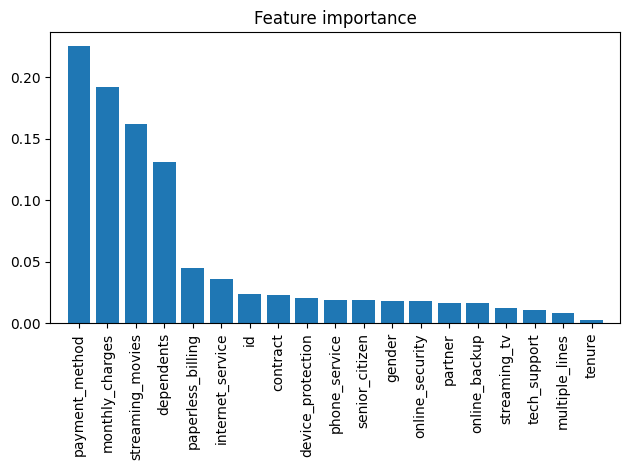

In [48]:
feature_labels = data_raw_input.columns[:19]                    # capture the feature labels for graphing
rf_manual = RandomForestClassifier(max_features=40, n_estimators=200, criterion='gini', n_jobs=-1, random_state=17)
rf_manual.fit(X_train, y_train)                        # fit the model
importances = rf_manual.feature_importances_                    # get the importance values

# Show the relative importance of each feature per the model
plot_importances(X_train, feature_labels, importances) # graph the importance of each class in the reduced features

In [49]:
smote = SMOTE()

In [50]:
# do PCA
pca = PCA(n_components=6)                   # break into 6 components based on what the plot above looks like is a good cutoff
X_pca = pca.fit_transform(X_train, y_train) # fit and transform the features

In [51]:
# do PCA
pca = PCA(n_components=6)                   # break into 6 components based on what the plot above looks like is a good cutoff
X_pca = pca.fit_transform(X_train, y_train) # fit and transform the features

# Test a simple model to see if it's reasonably better
# train, tune hyperparameters, and output scoring for the logistic regression model
param_grid = {'solver': ['liblinear', 'newton-cg', 'saga', 'lbfgs'], 
              'C': [0.001, 0.01, 1.0, 3.0, 5.0, 7.0, 10.0, 12.0]}

# Tune the hyperparameters "solver" and "C" for the LR model using the RandomizedSearchCV cross validation.
# I'm using the macro F1 score to score the folds and 5-fold cross validation.
lr_pca = tune_model(LogisticRegression(random_state = 17, max_iter=1000, n_jobs=-1), param_grid, X_train, y_train, 'roc_auc')

y_pred = lr_pca.predict(X_pca)
print(accuracy_score(y_train, y_pred))
print(f1_score(y_train, y_pred, average='macro'))

c:\github\uwf-venv-breast-cancer\Lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(
c:\github\uwf-venv-breast-cancer\Lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(
c:\github\uwf-venv-breast-cancer\Lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(
c:\github\uwf-venv-breast-cancer\Lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(
c:\github\uwf-venv-breast-cancer\Lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effec

0.8415316656685166
{'solver': 'liblinear', 'C': 10.0}


ValueError: X has 6 features, but LogisticRegression is expecting 19 features as input.

In [ ]:
# declare a logistic regression model I can use to try PCA and feature selection and try LR model
lr_sel = tune_model(LogisticRegression(random_state = 17, max_iter=1000, n_jobs=-1), param_grid, X_train, y_train, 'roc_auc')

# Now we have a model, select the best features from it to continue training.
sfm = SelectFromModel(lr_sel, prefit=True, threshold=0.03)
lr_sel = sfm.fit_transform(X_train, y_train)
X_train_selected = sfm.fit_transform(X_train)


In [ ]:
# train, tune hyperparameters, and output scoring for the Random Forest model
# Note I did one just the cell before this but I'm letting the cross validator optimize the hyperparameters here
param_grid = {'criterion': ['gini', 'entropy'], 'n_estimators': [50, 100, 150, 200, 300], 
              'max_features': [60, 80, 100, 120, 150, 175], 
              'max_depth': [25, 50, 75, 100, None]}

# declare a logistic regression model I can use to try PCA and feature selection and try LR model
lr_sel = tune_model(RandomForestClassifier(n_jobs=-1), param_grid, X_train, y_train, 'roc_auc')

# Now we have a model, select the best features from it to continue training.
sfm = SelectFromModel(lr_sel, prefit=True, threshold=0.03)
X_train_selected = sfm.fit_transform(X_train)


In [ ]:

tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=1,
                              random_state=1)

ada = AdaBoostClassifier(estimator=tree,
                         n_estimators=500, 
                         learning_rate=0.1,
                         random_state=1)

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print(f'Decision tree train/test accuracies '
      f'{tree_train:.3f}/{tree_test:.3f}')

bag = ada.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred) 
bag_test = accuracy_score(y_test, y_test_pred) 
print(f'Bagging train/test accuracies '
      f'{bag_train:.3f}/{bag_test:.3f}')

In [ ]:
# Doing the same creation, tuning, scoring of a Decision Tree
param_grid = {'criterion': ['gini', 'entropy', 'log_loss'], 
              'max_features': [40, 60, 80],
              'max_depth': [20, 50, 100, None]}

dtree = tune_model(DecisionTreeClassifier(random_state=17), 
                              param_grid, X_train, y_train, 'roc_auc')

y_pred = dtree.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred, average='macro'))
print(roc_auc_score(y_test, y_pred))

0.665650395670746
{'max_features': 80, 'max_depth': 20, 'criterion': 'log_loss'}
0.726788882318155
0.6564845822106218
0.6578001482432465


c:\github\uwf-venv-breast-cancer\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [ ]:
print(X_test[:5])

      gender  senior_citizen  partner  dependents    tenure  phone_service  \
3767       0        2.324000        0           0 -1.265367              1   
3248       1        2.324000        1           0 -0.654846              1   
3964       1       -0.430293        1           1  1.543031              1   
5415       0        2.324000        0           0  1.095315              1   
4779       0       -0.430293        0           0 -0.736249              1   

      multiple_lines  internet_service  online_security  online_backup  \
3767               0                 1                0              0   
3248               2                 1                0              0   
3964               2                 2                1              1   
5415               2                 1                2              2   
4779               2                 1                0              0   

      device_protection  tech_support  streaming_tv  streaming_movies  \
3767         

In [ ]:

# Do predictions on the submission test set and save the output as csv
data_test_input = pd.read_csv('datasets/test.csv') # get the test inputs

df_output = pd.DataFrame()
# remove the ID column and the save it in output_ids
df_output['id'] = data_test_input['id']                 # set the IDs we'll output but don't predict on them
data_test_input = data_test_input.drop('id', axis=1)    # drop the id columns

# Need to encode the test data
# This uses the tranformers we trained earlier as feature_encoder
X_test_for_out = transform_features(data_test_input, transform_only=True)

# Get the probabilities of class 1 (will churn)
prob_for_samples = dtree.predict_proba(X_test_for_out)
df_output['label'] = prob_for_samples[:,1]

print(df_output)



0       3320.75
1       6471.85
2        524.35
3        249.95
4        660.05
         ...   
1404    2655.25
1405     331.60
1406    3888.65
1407    5688.45
1408    1743.50
Name: total_charges, Length: 1409, dtype: float64


KeyError: 'numerics'

In [ ]:
write_predictions(dtree, 'datasets/test.csv', 'sample_submission.csv')

0       3320.75
1       6471.85
2        524.35
3        249.95
4        660.05
         ...   
1404    2655.25
1405     331.60
1406    3888.65
1407    5688.45
1408    1743.50
Name: total_charges, Length: 1409, dtype: float64


KeyError: 'numerics'